Show that by-hand type conversion is needed.

The issue is: some modeling packages (such as xgboost) check that all their argument types are numeric, others attempt a silent type
conversion. This can cause of modeling power for columns that contain IDs that *happen* to look like integers, and get converted to numeric.

In [1]:
# import packages
import pandas
import numpy
import sklearn.linear_model
import vtreat
import seaborn
import matplotlib.pyplot

In [2]:
# build an example system
d = pandas.DataFrame({
    'x': [i for i in range(4)] + [i for i in range(4)],
})
d['y'] = d.x % 2
d['x'] = d.x.astype('str')  # x is now a string, this is often a signal it should not be treated as numeric.

d

,x,y
0,0,0
1,1,1
2,2,0
3,3,1
4,0,0
5,1,1
6,2,0
7,3,1


In [3]:
model_vars = ['x']
outcome = 'y'

In [4]:
model_bad = sklearn.linear_model.LogisticRegression()
model_bad.fit(d.loc[:, model_vars], d[outcome])

LogisticRegression()

In [5]:
model_bad.coef_

array([[0.59528927]])

In [6]:
# vars(model_bad)
one_index = numpy.where(model_bad.classes_ == 1)[0][0]

plot_frame_bad = pandas.DataFrame({
    'y': d[outcome],
    'prediction': model_bad.predict_proba(d.loc[:, model_vars])[:, one_index]
})

plot_frame_bad

,y,prediction
0,0,0.290505
1,1,0.426133
2,0,0.573867
3,1,0.709495
4,0,0.290505
5,1,0.426133
6,0,0.573867
7,1,0.709495


Text(0.5, 1.0, 'bad predictions conditioned on actual outcome')

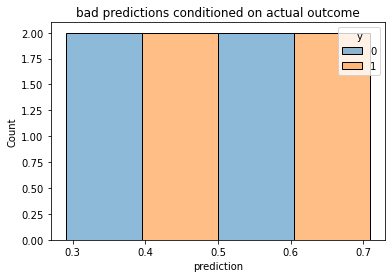

In [7]:
seaborn.histplot(data=plot_frame_bad, x='prediction', hue='y')
matplotlib.pyplot.title('bad predictions conditioned on actual outcome')

Notice the above preduction performance is bad, the model mixes postives and negatives.

Now lets try proper re-encoding of string variables as dummies or indicators (similar to `sklearn.preprocessing.OneHot`).

In [8]:
transform = vtreat.UnsupervisedTreatment(
    cols_to_copy = outcome,  # columns to "carry along" but not treat as input variables
    params = vtreat.unsupervised_parameters({
         'coders': {'clean_copy',
                    'missing_indicator',
                    'indicator_code',
                   }
    })
)

d_train = transform.fit_transform(d)

d_train

,y,x_lev_3,x_lev_0,x_lev_2,x_lev_1
0,0,0.0,1.0,0.0,0.0
1,1,0.0,0.0,0.0,1.0
2,0,0.0,0.0,1.0,0.0
3,1,1.0,0.0,0.0,0.0
4,0,0.0,1.0,0.0,0.0
5,1,0.0,0.0,0.0,1.0
6,0,0.0,0.0,1.0,0.0
7,1,1.0,0.0,0.0,0.0


In [9]:
new_vars = transform.score_frame_.variable[transform.score_frame_.recommended].to_list()
new_vars

['x_lev_3', 'x_lev_0', 'x_lev_2', 'x_lev_1']

In [10]:
model_good = sklearn.linear_model.LogisticRegression()
model_good.fit(d_train.loc[:, new_vars], d_train[outcome])

LogisticRegression()

In [11]:
{v: c for v, c in zip(new_vars, model_good.coef_[0])}

{'x_lev_3': 0.6748022104535976,
 'x_lev_0': -0.6748022104535976,
 'x_lev_2': -0.6748022104535976,
 'x_lev_1': 0.6748022104535976}

In [12]:
one_index_good = numpy.where(model_good.classes_ == 1)[0][0]

plot_frame_good = pandas.DataFrame({
    'y': d_train[outcome],
    'prediction': model_good.predict_proba(d_train.loc[:, new_vars])[:, one_index_good]
})

plot_frame_good

,y,prediction
0,0,0.337422
1,1,0.662578
2,0,0.337422
3,1,0.662578
4,0,0.337422
5,1,0.662578
6,0,0.337422
7,1,0.662578


Text(0.5, 1.0, 'good predictions conditioned on actual outcome')

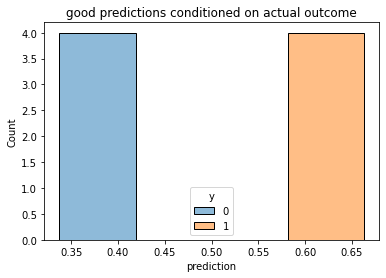

In [13]:
seaborn.histplot(data=plot_frame_good, x='prediction', hue='y')
matplotlib.pyplot.title('good predictions conditioned on actual outcome')

Notice now the model separates positives from negatives. I.e. it has learned the concept.